## One sample test для среднего

В этом ноутбуке мы посмотрим на одновыборочный тест для среднего и пробежимся по p-hacking.

Для чего нужен одновыборочный тест? Такой тест позволяет проверить равенство среднего генеральной совокупности некому значению. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Сгенерируем нашу генеральную совокупность. Пусть это будет средний чек транзакции в компании.
mean = 100
standard_deviation = 10
N = 100_000

np.random.seed(100)
population = np.random.normal(mean, standard_deviation, N)

In [3]:
population_mean = np.mean(population)
population_standard_deviation = np.std(population)
print('Population mean: {}, \nPopulation standard deviation: {}'.format(population_mean, population_standard_deviation))

Population mean: 100.0276477029241, 
Population standard deviation: 9.960105302635597


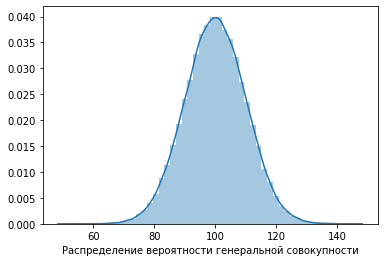

In [4]:
sns.distplot(population, axlabel='Распределение вероятности генеральной совокупности')

Компания провела масшатбную реструктуризацию отдела продаж и теперь нужно вяснить, как это повлияло на средний чек продажи.


Пришло время определиться с гипотезой. Да, гипотеза задается еще до того, как у нас на руках есть выборка.

H0: Средний чек не изменен и будет равен 100

H1: Средний чек не будет равен 100

Таже зададим уровень значимости альфа равное 0.05

In [5]:
# И скажем, что  реструктуризация сработала (но аналитик пока этого не знает)
new_population = population + 1

# Чтобы это проверить мы случайным образом выберем n сотрудников
n = 10
np.random.seed(100)
sample = np.random.choice(new_population, n)

sample_mean = sample.mean()
sample_standard_deviation = sample.std()
print('Sample mean: {}, \nSample standard deviation: {}'.format(sample_mean, sample_standard_deviation))

Sample mean: 103.79311169514233, 
Sample standard deviation: 12.496779708187344


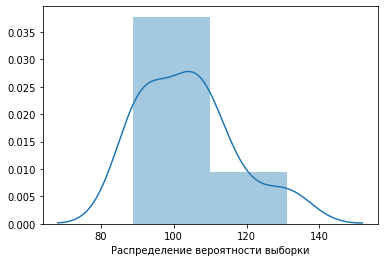

In [6]:
sns.distplot(sample, axlabel='Распределение вероятности выборки')

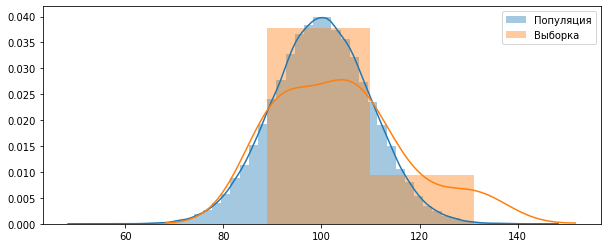

In [7]:
plt.figure(figsize=(10,4))
sns.distplot(population, label='Популяция')
sns.distplot(sample, label='Выборка')

plt.legend()

### Приступаем к тесту

Но сначала нам нужно убедиться, что мы вообще имеем право его проводить. Для этого наши данные должны удовлетворять трем критериям:

- Критерий случайности. 
- Критерий независимости.
- Критерий нормальности.

С легкостью проходим все проверки:

- Да, мы выбрали этих n человек случайно.
- Наша выборка намного меньше генеральной совокупности, тут все ок.
- Генеральная совокупность распределена нормально

In [8]:
#Напишем функцию, которая будет считать двухсторонний одновыборочный тест для среднего.
def one_sample_z_test_for_mean(sample=sample, alpha=0.05):
    s_mean = np.mean(sample)
    z_score = np.abs((s_mean - population_mean) / (population_standard_deviation / np.sqrt(n)))
    p_value = (1 - st.norm.cdf(z_score)) * 2
    answer = 'reject H0' if p_value < alpha else 'Do not reject H0'
    return (answer, p_value)

In [9]:
one_sample_z_test_for_mean(sample)

('Do not reject H0', 0.23188637428726677)

Но почему наш тест не показал, что изменения значимы? Тут мы совершили ошибку второго рода (когда нужно было отвергнуть нулевую гипотезу, но мы ее не отвергли.) По другому можно сказать, что у теста маленькая стат. мощность. Как увеличить мощность теста?

Один из способов задать больший критерий значимости:

In [10]:
one_sample_z_test_for_mean(sample, alpha=0.25)

('reject H0', 0.23188637428726677)

Более правильный способ - это увелить выборку n.

In [11]:
n = 1000
np.random.seed(100)
sample = np.random.choice(new_population, n)

sample_mean = sample.mean()
sample_standard_deviation = sample.std()
print('Sample mean: {}, \nSample standard deviation: {}'.format(sample_mean, sample_standard_deviation))

Sample mean: 101.1885570797677, 
Sample standard deviation: 10.19569564706877


In [12]:
one_sample_z_test_for_mean(sample)

('reject H0', 0.00022796541143610405)

### P-hacking

Когда мы задаем alpha на каком-то уровне, то одновременно задаем шанс совершить ошибку первого рода: отвергнуть нулевую гипотезу, когда ее отвергать не стоило.

Этим пользуются недобросовестные ученые и аналитики: проводят эксперимент множество раз, пока не получат нужное значение p-value.

In [13]:
# Напишем функцию, которая будет будет attempts раз брать выборку размером n из популяции и сохранять p-value
def generate_pvalues_from_samples(attempts):
    p_values = []
    n = 1000
    for i in range(attempts):
        new_sample = np.random.choice(population, n)
        p_value = one_sample_z_test_for_mean(new_sample)[1]
        p_values.append(p_value)   
    return np.array(p_values)

In [14]:
attempts = 1000
p_values = generate_pvalues_from_samples(attempts)

<BarContainer object of 1000 artists>

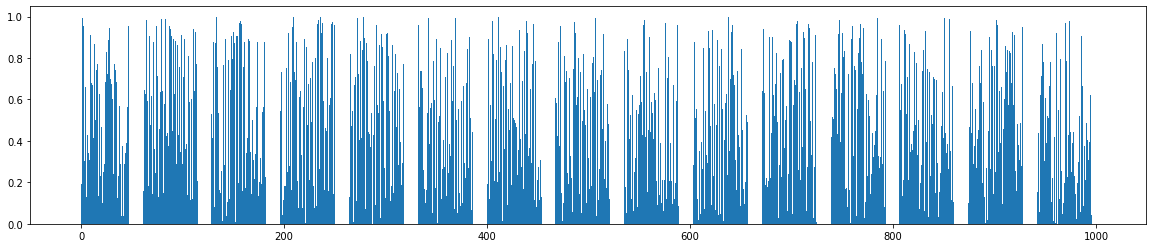

In [15]:
#Отобразим на графике получившиеся p-values
x = np.arange(attempts)

fig, axes = plt.subplots(figsize=(20,4))
axes.bar(x, p_values)

In [16]:
def calculate_first_error(p_list):
    return len(p_list[p_list<0.05])/ len(p_list)

first_error_calculated = calculate_first_error(p_values)
print('{} - такой шанс получить ошибку первого рода у нас получился'.format(first_error_calculated))

0.049 - такой шанс получить ошибку первого рода у нас получился


### T-распределение

В примерах выше для расчета z_score я использовал стандартное отклонение популяции. Но кто сказал, что оно будет нам известно? Оно почти всегда неизвестно. Заменим стандартное отклонение популяции на стандартное отклонении выборки. 

In [17]:
# Заменим standart_deviation на sample_standart_deviation

def one_sample_t_test_for_mean(sample=sample, alpha=0.05):
    s_mean = sample.mean()
    s_standard_deviation = np.std(sample)
    t_score = np.abs((s_mean - mean) / (s_standard_deviation / np.sqrt(n)))
    df = n - 1
    p_value = (1 - st.t.cdf(t_score, df)) * 2
    answer = 'reject H0' if p_value < alpha else 'Do not reject H0'
    return (answer, p_value)

In [18]:
n = 1000
np.random.seed(100)
sample = np.random.choice(new_population, n)

one_sample_t_test_for_mean(sample)

('reject H0', 0.00023967942019842425)

### Провека с помощью пакета scipy.stats

In [19]:
statistic, pvalue = st.ttest_1samp(sample,mean)

In [20]:
if pvalue < 0.05:
    print(pvalue, 'reject H0')
else:
    print(pvalue, 'Do not reject H0')

0.00024139727390375137 reject H0
